In [1]:
## Data related
import pandas as pd, numpy as np

## Data Visualization
import matplotlib.pyplot as plt
from cycler import cycler

## Sampling and feature encoding
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## Modeling
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

## Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline

### Load Recent Labeled Sentence Data

In [2]:
df = pd.read_csv("documents_to_sentences_labeled-09-04-2020.csv")

### Check Class Balance

Based on 19k sentences, the largest class is only a mere 500-ish observations in comparison (only 2%).  This is a very unbalanced dataset so we may need to employ some methods to control for the dominance of non-label sentences.

In [3]:
df.head(10).tail(1).values

array([[9, 0,
        '010 400 Divisadero SHAC LOI 09.10.18.pdf.png.processed.pdf',
        'Purchase Price: Thirty—Three Million Five Hundred Thousand Dollars ($33, 500,000.00) to be paid ALL CASH at the close of escrow.',
        'purchase_price']], dtype=object)

<AxesSubplot:title={'center':'Total sentences by label (of 19767)'}>

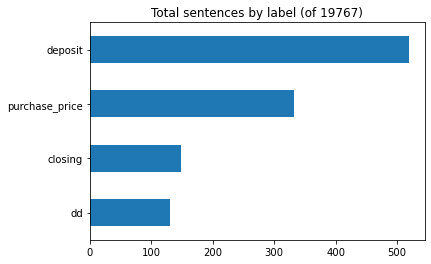

In [4]:
df['target_class'].value_counts().sort_values().plot(kind="barh", title = f"Total sentences by label (of {df.shape[0]})")

In [7]:
total = df.shape[0]
df['target_class'].value_counts() / total

none              0.942783
deposit           0.026256
purchase_price    0.016796
closing           0.007538
dd                0.006627
Name: target_class, dtype: float64

### Encode NaN Classes
Null target_class values essentially mean "no class" but our ML library doesn't know how to ingest those values.  So we will set them to "none".

In [8]:
df['target_class'] = df['target_class'].fillna("none")

### Encode Targets to Numeric

In [9]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['target_class'])

In [10]:
encoder.classes_

array(['closing', 'dd', 'deposit', 'none', 'purchase_price'], dtype=object)

### Sample Data

This is a somewhat imablanced dataset meaning there are more non-labled sentences than there are sentences which have labels.  We may need to tune this side of our modeling process iteratively to improve results.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[['sentence']], y_encoded, test_size = .3)

### Custom Sentence Vectorizer for Pipeline

This particular step is necessary post-modeling for new data to be treated as "sentences" rather than an entire document.

In [103]:
df['sentence'].values

array(['SUMMERHILL .', '.',
       'COMMUNITIES OF DISTINCTION September 10, 2018 Mr. Brett Betzler Moran & Company 2 Embarcadero Center, 8th Floor San Francisco, CA 94111 Letter of Intent for the Purchase of Ammption and Assignment of PSA of approximately 0.94 acres located at 400 Divisadero El Camino Real., City of San Francisco, County of San Francisco (the " Property") Dear Brett: SummerHill Housing Apartment Communities ("Buyer" or “SummerHill") is pleased to present this Letter of Intent to enter into a contract of sale with the Genesis Real Estate Group ("Seller”) for the Assumption and Assignment of PSA of the above-referenced Property, consisting of approximately 0.94 acres in San Francisco.',
       ..., 'Mark H. Stem Senior Vice President.',
       'Acquisitions Accepted and agreed to this day of , 2012.',
       'Seller: By ——————— Its Page 5 of5 4:'], dtype=object)

In [105]:
test_raw = [
    ("doc1", """LETTER OF INTENT 4/11/2019 Submitted via email To: Kaohu Berg-Hee Dear Mr. Berg-Hee: Interstate Equities Corporation (the “Buyer”) is pleased to set forth certain terms and conditions upon which we would negotiate the purchase of the herein referenced Property from the Owner of Record (the “Seller’). This Letter of Intent summarizes the basis upon which Purchaser would be willing to enter into a binding contract (the “Purchase Agreement”) to acquire the Property. 1. Property Address: Courtyards at 65th Street 1465 65th Street Emeryville, CA 94608 Consisting of 331 legal units 2. Purchase Price: Purchaser will purchase the Property(s) for $172,000,000 payable in cash at the Closing as hereinafter defined. 3. Purchase Agreement: Purchaser shall prepare a contract and submit it for approval within five (5) days after execution of this Letter of Intent. 4. Earnest Money Deposit: Within five (5) business days after the full execution of the Purchase Agreement, Purchaser shall deposit with First American Title (the “Escrow Company”) as escrow agent, $5,160,000 to be held by such agent pending the Closing. 5. Title: Title to the Property shall be conveyed by Seller to Purchaser or affiliate at the closing by Grant Deed, free and clear of all liens and encumbrances, subject only to such exceptions as may be approved by Purchaser. Title services shall be provided by First American Title Company. 6. Physical Contingency: Purchaser shall have twenty-five (25) day Inspection Period from the effective date of the execution of the Purchase Agreement and receipt of due diligence documents to determine the suitability of the Property for purchase. Seller shall grant Purchaser and its agents a right of entry on the Property to obtain appraisals and to perform engineering and environmental tests and such other studies necessary in connection with Purchaser’s evaluation of the Property. In addition, Purchaser shall review zoning and other governmental regulations affecting the Property. In the event Purchaser determines that the Property are not suitable for purchase, in its sole and absolute discretion, the Purchase Agreement will terminate, the Earnest Money will be returned to Purchaser and the parties will have no further obligations to one another. Page 1 of 3 In order to facilitate Purchaser’s due diligence investigation and analysis, Seller agrees to furnish to Purchaser within five (5) business days after Seller’s Execution of this Letter of Intent all documents, records and other information in its possession or accessible, relating to the Property, including but not limited to, the following: a Preliminary title report with all underlying documents, dated no earlier than the date of this Letter of Intent; b Current as-built plans and survey with legal description if in possession of owner; c) Real estate tax bills for the prior three years with complete files on any pending proceedings; d Leases, service contracts and other agreements; e Current and previous environmental, asbestos, engineering or other physical reports in Seller’s possession, as well as an explanation of remediation work performed; f) Any appraisals of the Property; g Property operating statements for the prior three full years and current year to date, including utility bills for the same periods; h A current rent roll including concessions, lease expiration, delinquency, security deposits and tenant complaints; i) Copies of all licenses, building permits and certificates of occupancy, a zoning compliance letter, and any amendments; j) Personal property inventory; k) Complete files on any pending or threatened litigation at or affecting the Property; l) Copies of any rental restrictions and their termination dates, indentures, regulatory agreements, compliance letters, and bond documents; m) List of employees and payroll information. Ts Closing: The Closing of the purchase shall occur thirty-five (35) days after satisfaction of Buyer’s contingencies with the recoding of a grant deed from Seller to Purchaser. 8. Closing Costs: Transfer tax, Escrow and Title fees shall be paid in accordance with county custom. Each party will pay its own legal fees. 9. Confidentiality: Except as required by law, Purchaser and Seller hereby agree to maintain the confidentiality, other than to their affiliates’, officers, employees, advisors, agents, lenders and consultants, of all information exchanged that is not public information, as well as the fact that Purchaser has made this offer and the terms and conditions herein. 10. Expression of Intent: With the exception of paragraph 11 (Governing Law) below and this paragraph 10, this letter is not intended to be binding and will not give rise to any right or obligation based on any theory, whether legal, equitable or otherwise (including any right to continue negotiations), it being agreed that only a subsequent formal written contract, if executed and delivered by both parties, will bind the parties as to any matter (other than paragraph 11 and this paragraph 10, which are intended to be binding). Page 2 of 3 11. Governing Law: This letter shall be given effect and construed by application of the laws of the state of California (without regard to the principles thereof governing conflicts of laws), and any action or proceeding arising hereunder shall only be brought in the courts of the state of California or in a United States district court sitting in the state of California. The parties both consent to the jurisdiction of the courts of the state of California and/or a United States district court sitting in the state of California. The parties agree that monetary damages may not alone be sufficient to remedy any breach by any party of any term or provision of this letter. Accordingly, the parties acknowledge that remedies at law may be inadequate to protect against breach of this letter and the parties hereby agree in advance to the granting of equitable relief, including injunction and specific performance, without proof of actual damages, in the event of any breach hereof. Such remedies shall not be deemed to be the exclusive remedies for a breach of this letter but shall be in addition to all other remedies available at law or equity. In the event of litigation relating to this letter, if a court of competent jurisdiction determines that any party, or its directors, officers, partners, members, employees or agents have breached this letter then the breaching party shall be liable and pay to the non-breaching party the reasonable legal fees incurred by the non- breaching party in connection with such litigation, including an appeal therefrom. 12. Notice: All notices to Purchaser shall be addressed as follows: Interstate Equities Corporation 4970 El Camino Real #220 Los Altos, CA. 94022 Attention: Marshall Boyd The terms and provisions set forth in this Letter of Intent, together with other terms and provisions relating to this transaction, shall be set forth more completely in the Purchase Agreement and each party hereby agrees to diligently proceed with the negotiation, preparation and execution of such an agreement. If these terms are agreeable, please execute your acceptance below. In the event Purchaser does not receive a copy of this Letter of Intent signed by Seller within 5 days of its date, it shall be deemed null and void. Sincerely, : 04/11/2019 President ACCEPTED AND AGREED TO this day of , 2019: By: Title: Page 3 of 3 """),
    ("doc2", """LETTER OF INTENT 4/11/2019 Submitted via email To: Kaohu Berg-Hee Dear Mr. Berg-Hee: Interstate Equities Corporation (the “Buyer”) is pleased to set forth certain terms and conditions upon which we would negotiate the purchase of the herein referenced Property from the Owner of Record (the “Seller’). This Letter of Intent summarizes the basis upon which Purchaser would be willing to enter into a binding contract (the “Purchase Agreement”) to acquire the Property. 1. Property Address: Courtyards at 65th Street 1465 65th Street Emeryville, CA 94608 Consisting of 331 legal units 2. Purchase Price: Purchaser will purchase the Property(s) for $172,000,000 payable in cash at the Closing as hereinafter defined. 3. Purchase Agreement: Purchaser shall prepare a contract and submit it for approval within five (5) days after execution of this Letter of Intent. 4. Earnest Money Deposit: Within five (5) business days after the full execution of the Purchase Agreement, Purchaser shall deposit with First American Title (the “Escrow Company”) as escrow agent, $5,160,000 to be held by such agent pending the Closing. 5. Title: Title to the Property shall be conveyed by Seller to Purchaser or affiliate at the closing by Grant Deed, free and clear of all liens and encumbrances, subject only to such exceptions as may be approved by Purchaser. Title services shall be provided by First American Title Company. 6. Physical Contingency: Purchaser shall have twenty-five (25) day Inspection Period from the effective date of the execution of the Purchase Agreement and receipt of due diligence documents to determine the suitability of the Property for purchase. Seller shall grant Purchaser and its agents a right of entry on the Property to obtain appraisals and to perform engineering and environmental tests and such other studies necessary in connection with Purchaser’s evaluation of the Property. In addition, Purchaser shall review zoning and other governmental regulations affecting the Property. In the event Purchaser determines that the Property are not suitable for purchase, in its sole and absolute discretion, the Purchase Agreement will terminate, the Earnest Money will be returned to Purchaser and the parties will have no further obligations to one another. Page 1 of 3 In order to facilitate Purchaser’s due diligence investigation and analysis, Seller agrees to furnish to Purchaser within five (5) business days after Seller’s Execution of this Letter of Intent all documents, records and other information in its possession or accessible, relating to the Property, including but not limited to, the following: a Preliminary title report with all underlying documents, dated no earlier than the date of this Letter of Intent; b Current as-built plans and survey with legal description if in possession of owner; c) Real estate tax bills for the prior three years with complete files on any pending proceedings; d Leases, service contracts and other agreements; e Current and previous environmental, asbestos, engineering or other physical reports in Seller’s possession, as well as an explanation of remediation work performed; f) Any appraisals of the Property; g Property operating statements for the prior three full years and current year to date, including utility bills for the same periods; h A current rent roll including concessions, lease expiration, delinquency, security deposits and tenant complaints; i) Copies of all licenses, building permits and certificates of occupancy, a zoning compliance letter, and any amendments; j) Personal property inventory; k) Complete files on any pending or threatened litigation at or affecting the Property; l) Copies of any rental restrictions and their termination dates, indentures, regulatory agreements, compliance letters, and bond documents; m) List of employees and payroll information. Ts Closing: The Closing of the purchase shall occur thirty-five (35) days after satisfaction of Buyer’s contingencies with the recoding of a grant deed from Seller to Purchaser. 8. Closing Costs: Transfer tax, Escrow and Title fees shall be paid in accordance with county custom. Each party will pay its own legal fees. 9. Confidentiality: Except as required by law, Purchaser and Seller hereby agree to maintain the confidentiality, other than to their affiliates’, officers, employees, advisors, agents, lenders and consultants, of all information exchanged that is not public information, as well as the fact that Purchaser has made this offer and the terms and conditions herein. 10. Expression of Intent: With the exception of paragraph 11 (Governing Law) below and this paragraph 10, this letter is not intended to be binding and will not give rise to any right or obligation based on any theory, whether legal, equitable or otherwise (including any right to continue negotiations), it being agreed that only a subsequent formal written contract, if executed and delivered by both parties, will bind the parties as to any matter (other than paragraph 11 and this paragraph 10, which are intended to be binding). Page 2 of 3 11. Governing Law: This letter shall be given effect and construed by application of the laws of the state of California (without regard to the principles thereof governing conflicts of laws), and any action or proceeding arising hereunder shall only be brought in the courts of the state of California or in a United States district court sitting in the state of California. The parties both consent to the jurisdiction of the courts of the state of California and/or a United States district court sitting in the state of California. The parties agree that monetary damages may not alone be sufficient to remedy any breach by any party of any term or provision of this letter. Accordingly, the parties acknowledge that remedies at law may be inadequate to protect against breach of this letter and the parties hereby agree in advance to the granting of equitable relief, including injunction and specific performance, without proof of actual damages, in the event of any breach hereof. Such remedies shall not be deemed to be the exclusive remedies for a breach of this letter but shall be in addition to all other remedies available at law or equity. In the event of litigation relating to this letter, if a court of competent jurisdiction determines that any party, or its directors, officers, partners, members, employees or agents have breached this letter then the breaching party shall be liable and pay to the non-breaching party the reasonable legal fees incurred by the non- breaching party in connection with such litigation, including an appeal therefrom. 12. Notice: All notices to Purchaser shall be addressed as follows: Interstate Equities Corporation 4970 El Camino Real #220 Los Altos, CA. 94022 Attention: Marshall Boyd The terms and provisions set forth in this Letter of Intent, together with other terms and provisions relating to this transaction, shall be set forth more completely in the Purchase Agreement and each party hereby agrees to diligently proceed with the negotiation, preparation and execution of such an agreement. If these terms are agreeable, please execute your acceptance below. In the event Purchaser does not receive a copy of this Letter of Intent signed by Seller within 5 days of its date, it shall be deemed null and void. Sincerely, : 04/11/2019 President ACCEPTED AND AGREED TO this day of , 2019: By: Title: Page 3 of 3 """),
    ("doc3", """LETTER OF INTENT 4/11/2019 Submitted via email To: Kaohu Berg-Hee Dear Mr. Berg-Hee: Interstate Equities Corporation (the “Buyer”) is pleased to set forth certain terms and conditions upon which we would negotiate the purchase of the herein referenced Property from the Owner of Record (the “Seller’). This Letter of Intent summarizes the basis upon which Purchaser would be willing to enter into a binding contract (the “Purchase Agreement”) to acquire the Property. 1. Property Address: Courtyards at 65th Street 1465 65th Street Emeryville, CA 94608 Consisting of 331 legal units 2. Purchase Price: Purchaser will purchase the Property(s) for $172,000,000 payable in cash at the Closing as hereinafter defined. 3. Purchase Agreement: Purchaser shall prepare a contract and submit it for approval within five (5) days after execution of this Letter of Intent. 4. Earnest Money Deposit: Within five (5) business days after the full execution of the Purchase Agreement, Purchaser shall deposit with First American Title (the “Escrow Company”) as escrow agent, $5,160,000 to be held by such agent pending the Closing. 5. Title: Title to the Property shall be conveyed by Seller to Purchaser or affiliate at the closing by Grant Deed, free and clear of all liens and encumbrances, subject only to such exceptions as may be approved by Purchaser. Title services shall be provided by First American Title Company. 6. Physical Contingency: Purchaser shall have twenty-five (25) day Inspection Period from the effective date of the execution of the Purchase Agreement and receipt of due diligence documents to determine the suitability of the Property for purchase. Seller shall grant Purchaser and its agents a right of entry on the Property to obtain appraisals and to perform engineering and environmental tests and such other studies necessary in connection with Purchaser’s evaluation of the Property. In addition, Purchaser shall review zoning and other governmental regulations affecting the Property. In the event Purchaser determines that the Property are not suitable for purchase, in its sole and absolute discretion, the Purchase Agreement will terminate, the Earnest Money will be returned to Purchaser and the parties will have no further obligations to one another. Page 1 of 3 In order to facilitate Purchaser’s due diligence investigation and analysis, Seller agrees to furnish to Purchaser within five (5) business days after Seller’s Execution of this Letter of Intent all documents, records and other information in its possession or accessible, relating to the Property, including but not limited to, the following: a Preliminary title report with all underlying documents, dated no earlier than the date of this Letter of Intent; b Current as-built plans and survey with legal description if in possession of owner; c) Real estate tax bills for the prior three years with complete files on any pending proceedings; d Leases, service contracts and other agreements; e Current and previous environmental, asbestos, engineering or other physical reports in Seller’s possession, as well as an explanation of remediation work performed; f) Any appraisals of the Property; g Property operating statements for the prior three full years and current year to date, including utility bills for the same periods; h A current rent roll including concessions, lease expiration, delinquency, security deposits and tenant complaints; i) Copies of all licenses, building permits and certificates of occupancy, a zoning compliance letter, and any amendments; j) Personal property inventory; k) Complete files on any pending or threatened litigation at or affecting the Property; l) Copies of any rental restrictions and their termination dates, indentures, regulatory agreements, compliance letters, and bond documents; m) List of employees and payroll information. Ts Closing: The Closing of the purchase shall occur thirty-five (35) days after satisfaction of Buyer’s contingencies with the recoding of a grant deed from Seller to Purchaser. 8. Closing Costs: Transfer tax, Escrow and Title fees shall be paid in accordance with county custom. Each party will pay its own legal fees. 9. Confidentiality: Except as required by law, Purchaser and Seller hereby agree to maintain the confidentiality, other than to their affiliates’, officers, employees, advisors, agents, lenders and consultants, of all information exchanged that is not public information, as well as the fact that Purchaser has made this offer and the terms and conditions herein. 10. Expression of Intent: With the exception of paragraph 11 (Governing Law) below and this paragraph 10, this letter is not intended to be binding and will not give rise to any right or obligation based on any theory, whether legal, equitable or otherwise (including any right to continue negotiations), it being agreed that only a subsequent formal written contract, if executed and delivered by both parties, will bind the parties as to any matter (other than paragraph 11 and this paragraph 10, which are intended to be binding). Page 2 of 3 11. Governing Law: This letter shall be given effect and construed by application of the laws of the state of California (without regard to the principles thereof governing conflicts of laws), and any action or proceeding arising hereunder shall only be brought in the courts of the state of California or in a United States district court sitting in the state of California. The parties both consent to the jurisdiction of the courts of the state of California and/or a United States district court sitting in the state of California. The parties agree that monetary damages may not alone be sufficient to remedy any breach by any party of any term or provision of this letter. Accordingly, the parties acknowledge that remedies at law may be inadequate to protect against breach of this letter and the parties hereby agree in advance to the granting of equitable relief, including injunction and specific performance, without proof of actual damages, in the event of any breach hereof. Such remedies shall not be deemed to be the exclusive remedies for a breach of this letter but shall be in addition to all other remedies available at law or equity. In the event of litigation relating to this letter, if a court of competent jurisdiction determines that any party, or its directors, officers, partners, members, employees or agents have breached this letter then the breaching party shall be liable and pay to the non-breaching party the reasonable legal fees incurred by the non- breaching party in connection with such litigation, including an appeal therefrom. 12. Notice: All notices to Purchaser shall be addressed as follows: Interstate Equities Corporation 4970 El Camino Real #220 Los Altos, CA. 94022 Attention: Marshall Boyd The terms and provisions set forth in this Letter of Intent, together with other terms and provisions relating to this transaction, shall be set forth more completely in the Purchase Agreement and each party hereby agrees to diligently proceed with the negotiation, preparation and execution of such an agreement. If these terms are agreeable, please execute your acceptance below. In the event Purchaser does not receive a copy of this Letter of Intent signed by Seller within 5 days of its date, it shall be deemed null and void. Sincerely, : 04/11/2019 President ACCEPTED AND AGREED TO this day of , 2019: By: Title: Page 3 of 3 """)
]

test = pd.DataFrame(test_raw, columns = ["document", "text"])
test

,document,text
0,doc1,LETTER OF INTENT 4/11/2019 Submitted via email...
1,doc2,LETTER OF INTENT 4/11/2019 Submitted via email...
2,doc3,LETTER OF INTENT 4/11/2019 Submitted via email...


In [162]:
doc_sentences = []
for index, document, text in test.to_records():
    for sentence in nltk.sent_tokenize(text):
        doc_sentences.append((document, sentence))
    
pd.DataFrame(doc_sentences, columns = ['document', 'sentence']).set_index('document')

,sentence
document,
doc1,LETTER OF INTENT 4/11/2019 Submitted via email...
doc1,This Letter of Intent summarizes the basis upo...
doc1,1.
doc1,Property Address: Courtyards at 65th Street 14...
doc1,Purchase Price: Purchaser will purchase the Pr...
...,...
doc3,Notice: All notices to Purchaser shall be addr...
doc3,94022 Attention: Marshall Boyd The terms and p...
doc3,"If these terms are agreeable, please execute y..."


In [167]:
type(test) == 

True

In [194]:
import joblib
model = joblib.load("../ml/models/sentence_model.joblib")

test = nltk.sent_tokenize(test_raw[0][1])

list(({"sentence": row[0], "y_hat": row[1]} for row in zip(test, model.predict_proba(test).round(3).tolist())))

[{'sentence': 'LETTER OF INTENT 4/11/2019 Submitted via email To: Kaohu Berg-Hee Dear Mr. Berg-Hee: Interstate Equities Corporation (the “Buyer”) is pleased to set forth certain terms and conditions upon which we would negotiate the purchase of the herein referenced Property from the Owner of Record (the “Seller’).',
  'y_hat': [0.0, 0.0, 0.0, 1.0, 0.0]},
 {'sentence': 'This Letter of Intent summarizes the basis upon which Purchaser would be willing to enter into a binding contract (the “Purchase Agreement”) to acquire the Property.',
  'y_hat': [0.0, 0.0, 0.0, 1.0, 0.0]},
 {'sentence': '1.', 'y_hat': [0.0, 0.0, 0.0, 1.0, 0.0]},
 {'sentence': 'Property Address: Courtyards at 65th Street 1465 65th Street Emeryville, CA 94608 Consisting of 331 legal units 2.',
  'y_hat': [0.0, 0.0, 0.0, 1.0, 0.0]},
 {'sentence': 'Purchase Price: Purchaser will purchase the Property(s) for $172,000,000 payable in cash at the Closing as hereinafter defined.',
  'y_hat': [0.0, 0.0, 0.0, 0.0, 1.0]},
 {'sente

In [52]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/david.yerrington/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
import nltk

class SentenceTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for index, document, text in X.to_records():
            for sentence in nltk.sent_tokenize(text):
                doc_sentences.append((document, sentence))
        return nltk.sent_tokenize(X)
    
st = SentenceTokenizer()
st.transform(test)


TypeError: expected string or bytes-like object

### Pipeline

- Transform input so text can be modeled
- Fit model

>  This section can be run with different models by commenting / uncommenting the "model" step.

In [21]:
steps = [
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegressionCV(max_iter = 2000, multi_class = 'ovr', cv = 3))
    # ('model', SGDClassifier(loss = 'log'))
    # ('model', RandomForestClassifier())
    # ('model', MLPClassifier()) 
]

pipe = Pipeline(steps = steps)

## Fit model on core dataset with no sampling
pipe_model = pipe.fit(df['sentence'], y_encoded)

### Overall Accuracy with a basic logistic model is 99%

However, baseline accuracy of our primarily class is only .02.  We will have to examine other metrics for misclassification performance.

In [22]:
pipe_model.score(df['sentence'], y_encoded)

0.998330550918197

In [23]:
# Predicted classes
y_hat       = pipe_model.predict(df['sentence'])
y_hat_train = pipe_model.predict(X_train['sentence'])         ## Don't forget to train on this dataset as well
y_hat_test  = pipe_model.predict(X_test['sentence'])

# Predicted class probabilities
y_hat_prob         = pipe_model.predict_proba(df['sentence'])
y_hat_train_proba  = pipe_model.predict_proba(X_train['sentence']) 
y_hat_test_proba   = pipe_model.predict_proba(X_test['sentence'])

### Class ROC Curves

In [24]:
df['target_class'].value_counts()

none              18636
deposit             519
purchase_price      332
closing             149
dd                  131
Name: target_class, dtype: int64

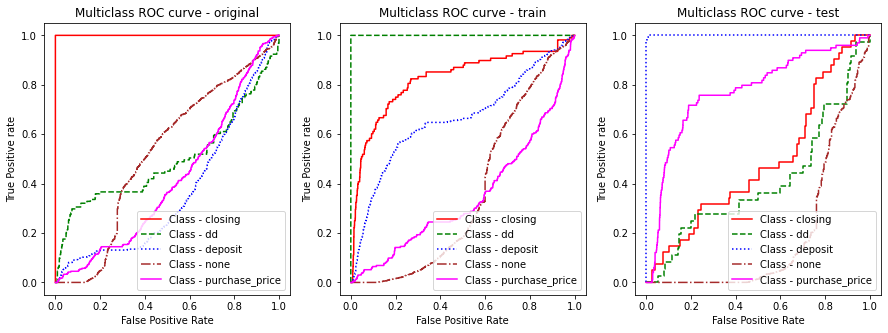

In [25]:
## Line color config
default_cycler = (cycler(color=['red', 'green', 'blue', 'brown', 'magenta']) + 
                  cycler(linestyle=['-', '--', ':', '-.', '-']))

plt.rc('axes', prop_cycle = default_cycler)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
ax = ax.ravel()

## Plotting with different datasets
datasets = [
    dict(
        name                = "original",
        y                   = y_encoded,
        y_hat               = pipe_model.predict(df['sentence']),
        y_hat_probabilities = pipe_model.predict_proba(df['sentence'])
    ),
    dict(
        name                = "train",
        y                   = y_train,
        y_hat               = pipe_model.predict(X_train['sentence']),
        y_hat_probabilities = pipe_model.predict_proba(X_train['sentence'])
    ),
    dict(
        name                = "test",
        y                   = y_test,
        y_hat               = pipe_model.predict(X_test['sentence']),
        y_hat_probabilities = pipe_model.predict_proba(X_test['sentence'])
    ),
]

for index, data in enumerate(datasets):
    ## Set confusion metrics per class
    fpr, tpr, thresh = {}, {}, {}
    for class_index, class_name in enumerate(encoder.classes_):
        fpr, tpr, threshold = roc_curve(
            data['y'], data['y_hat_probabilities'][:,index], 
            pos_label = class_index
        )
        ax[index].plot(fpr, tpr, label = f"Class - {class_name}")
        ax[index].set_title(f"Multiclass ROC curve - {data['name']}")
        ax[index].set_xlabel('False Positive Rate')
        ax[index].set_ylabel('True Positive rate')
        ax[index].legend(loc='best')


## Evalutation

### Precision (specificity), Recall (sensitivity), F1 (Harmonic Mean of precision and recall)

In [26]:
get_reports = lambda: \
    {
        data['name']: classification_report(
            data['y'], 
            data['y_hat'],
            target_names = encoder.classes_
        ) for index, data in enumerate(datasets)
    }
reports = get_reports()

print("Original Data\n--------------------------------------------------------\n", reports['original'], "\n\n")
print("Train Data\n--------------------------------------------------------\n", reports['train'], "\n\n")
print("Test Data\n--------------------------------------------------------\n", reports['test'], "\n\n")

Original Data
--------------------------------------------------------
                 precision    recall  f1-score   support

       closing       1.00      0.99      0.99       149
            dd       0.99      0.94      0.96       131
       deposit       0.98      0.97      0.98       519
          none       1.00      1.00      1.00     18636
purchase_price       1.00      1.00      1.00       332

      accuracy                           1.00     19767
     macro avg       0.99      0.98      0.99     19767
  weighted avg       1.00      1.00      1.00     19767
 


Train Data
--------------------------------------------------------
                 precision    recall  f1-score   support

       closing       1.00      0.98      0.99       108
            dd       0.99      0.95      0.97        95
       deposit       0.98      0.98      0.98       369
          none       1.00      1.00      1.00     13031
purchase_price       1.00      1.00      1.00       233

      accur

### Model Inference (Logistic model only)

In [27]:
## Feature names, words
features = pipe_model.named_steps['vectorizer'].get_feature_names()

## Coefficients
coefs = pipe_model.named_steps['model'].coef_


## Combine into dataframe
coefs_df = pd.DataFrame(coefs, columns = features, index = encoder.classes_)
coefs_df

,00,000,00000,000115004300,0004,0006,00065,000f3diershaﬂﬁeﬁvmhemypmtyﬁee,000i,000in,...,ﬂora,ﬂoss,ﬂow,ﬂré5,ﬂus,ﬂymxorl,ﬂz,ﬂé,ﬂﬂ,ﬂﬂﬂ
closing,-0.870436,0.177958,-0.001024,1.989105e-01,-0.000021,-0.000301,-0.000236,-6.353283e-04,-0.000072,-3.055121e-09,...,-0.000104,-0.000018,-0.002817,-0.000431,-1.127414e-03,-0.000724,-1.131908e-03,-0.000081,-0.000011,-4.255617e-10
dd,-0.430522,0.202302,-0.000112,-5.206353e-04,-0.000110,-0.000210,-0.000244,-9.551707e-05,-0.000438,-3.045379e-03,...,-0.000003,-0.000148,-0.002582,-0.000297,-5.966191e-04,-0.000299,-4.138822e-03,-0.000313,-0.002149,-8.283932e-06
deposit,0.217430,1.521982,-0.002109,-2.126874e-02,-0.000062,-0.000482,-0.000339,-6.109805e-04,-0.000133,8.083338e-02,...,-0.000124,-0.000064,-0.000167,-0.000364,-2.093025e-04,-0.000353,-5.153485e-05,-0.000451,-0.000014,-9.466224e-05
none,-0.547040,-2.461805,-1.619410,-1.446237e-08,0.000051,0.002963,0.001293,2.579422e-03,-0.008233,-2.371467e-01,...,0.000231,0.001444,0.002565,0.001767,2.445696e-03,0.001644,2.530188e-02,0.004212,0.000686,4.322870e-06
purchase_price,1.332518,3.664503,3.318717,-3.905544e-02,-0.000422,-0.000874,-0.000039,-1.409517e-07,0.013068,-9.510043e-08,...,-0.000718,-0.000004,-0.000320,-0.000148,-6.850217e-07,-0.000088,-4.293209e-07,-0.000058,-0.000096,-1.647807e-06


#### Coefs Plot of Top Absolute Values

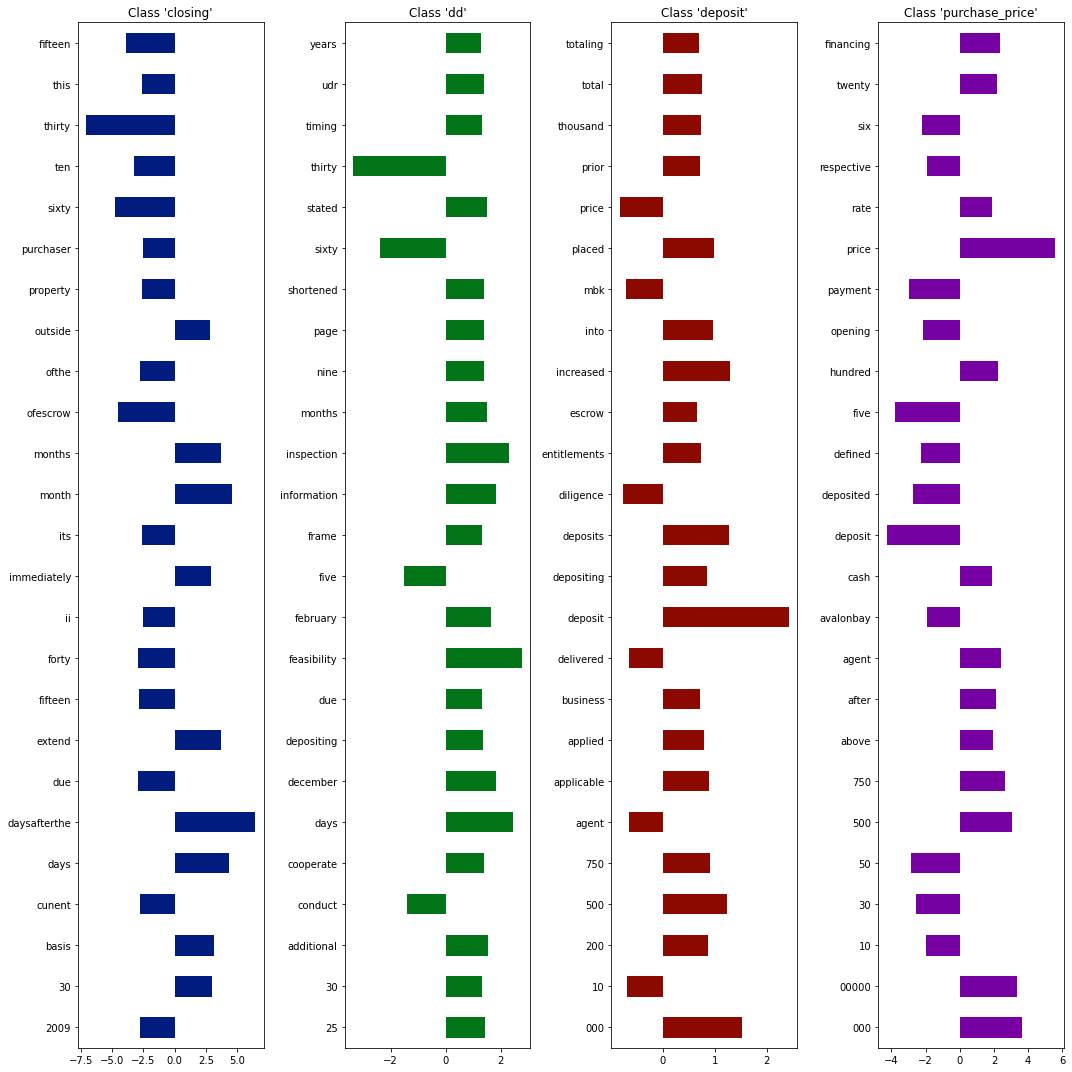

In [28]:
from matplotlib import style
style.use('seaborn-dark-palette')

def plot_top_ceofs(index = 'closing', limit = 25, ax = False, color = False):
    sorted_index = coefs_df.loc[index].abs().sort_values(ascending = False).head(limit).index
    return coefs_df.loc[index][coefs_df.loc[index].index.isin(sorted_index)].plot(
        title   = f"Class '{index}'",
        kind    = "barh", 
        ax      = ax,
        color   = color
    )

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 15))
ax = ax.ravel()
prop_iter = iter(plt.rcParams['axes.prop_cycle']) # for cycling through colors
for index, class_name in enumerate(coefs_df.index[coefs_df.index != "none"].tolist()):
    plot_top_ceofs(index = class_name, ax = ax[index], color=next(prop_iter)['color'])
    
plt.tight_layout()

### Basic Predict example

In [31]:
sentence = input(prompt = "Enter a sentence to classify:")
prediction = pipe_model.predict([sentence])
probas = pipe_model.predict_proba([sentence])
print(f"Predicted class: {encoder.classes_[prediction[0]]}")
print("Class probabilities:")
class_probas = {class_name: probas[0][index].round(4) for index, class_name in enumerate(encoder.classes_)}
print(class_probas)

Enter a sentence to classify: Earnest Money Deposit: Within five (5) business days after the full execution of the Purchase Agreement, Purchaser shall deposit with First American Title (the “Escrow Company”) as escrow agent, $5,160,000 to be held by such agent pending the Closing.


Predicted class: deposit
Class probabilities:
{'closing': 0.0, 'dd': 0.0002, 'deposit': 0.9799, 'none': 0.0199, 'purchase_price': 0.0}
